### Bike Sharing Dataset 

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
#from sklearn.pipeline import Pipeline

#from sklearn.model_selection import train_test_split
#import sys
#import pickle

import os
import pandas_profiling
import matplotlib.pyplot as plt
#import tensorflow as tf
import tqdm
import re
import warnings
warnings.filterwarnings('ignore')

In [30]:
data_dir = os.getcwd().replace('/src', '/data')

In [31]:
os.listdir(data_dir)

['day.csv',
 'hour.csv',
 'neural_network.png',
 'pima-indians-diabetes.csv',
 'Readme.txt']

In [32]:
data_path = data_dir + '/hour.csv'
rides = pd.read_csv(data_path)
rides.head(5)

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [33]:
rides.describe()

instant        season            yr          mnth            hr  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      2.501640      0.502561      6.537775     11.546752   
std     5017.0295      1.106918      0.500008      3.438776      6.914405   
min        1.0000      1.000000      0.000000      1.000000      0.000000   
25%     4345.5000      2.000000      0.000000      4.000000      6.000000   
50%     8690.0000      3.000000      1.000000      7.000000     12.000000   
75%    13034.5000      3.000000      1.000000     10.000000     18.000000   
max    17379.0000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.028770      3.003683      0.682721      1.425283      0.496987   
std        0.167165      2.005771      0.465431      0.639357      0.192556   
min        0.000000      0.000000      0.000000      1.000000      0.020000   
25%        0.000000      1.000000      0.000000      1.000000      0.340000   
50%        0.000000      3.000000      1.000000      1.000000      0.500000   
75%        0.000000      5.000000      1.000000      2.000000      0.660000   
max        1.000000      6.000000      1.000000      4.000000      1.000000   

              atemp           hum     windspeed        casual    registered  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.475775      0.627229      0.190098     35.676218    153.786869   
std        0.171850      0.192930      0.122340     49.305030    151.357286   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.333300      0.480000      0.104500      4.000000     34.000000   
50%        0.484800      0.630000      0.194000     17.000000    115.000000   
75%        0.621200      0.780000      0.253700     48.000000    220.000000   
max        1.000000      1.000000      0.850700    367.000000    886.000000   

                cnt  
count  17379.000000  
mean     189.463088  
std      181.387599  
min        1.000000  
25%       40.000000  
50%      142.000000  
75%      281.000000  
max      977.000000

In [34]:
rides.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [35]:
#pandas_profiling.ProfileReport(rides)

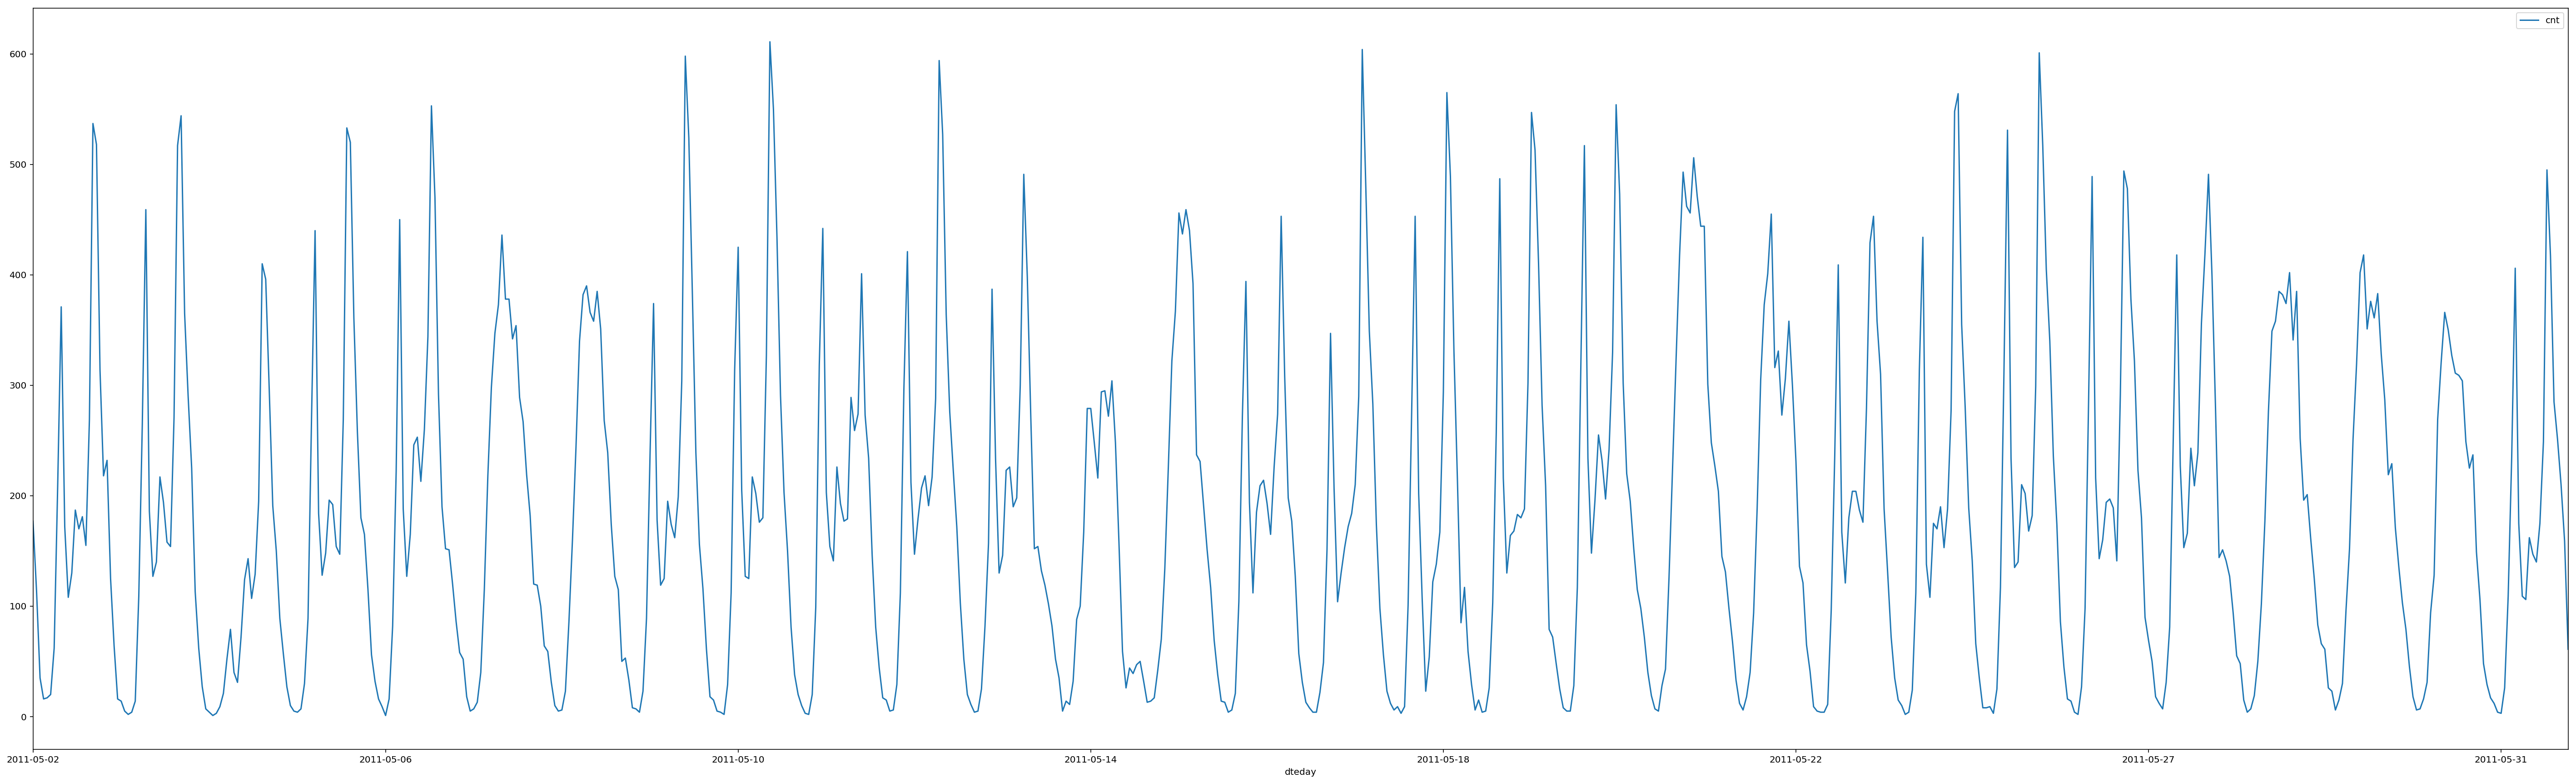

In [36]:
rides[('2011-05-01' < rides['dteday']) & (rides['dteday'] < '2011-06-01')].plot(x='dteday', y='cnt', figsize=(50,15))

In [37]:
# dummy variables #
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

yr  holiday  temp   hum  windspeed  casual  registered  cnt  season_1  \
0   0        0  0.24  0.81        0.0       3          13   16         1   
1   0        0  0.22  0.80        0.0       8          32   40         1   
2   0        0  0.22  0.80        0.0       5          27   32         1   
3   0        0  0.24  0.75        0.0       3          10   13         1   
4   0        0  0.24  0.75        0.0       0           1    1         1   

   season_2    ...      hr_21  hr_22  hr_23  weekday_0  weekday_1  weekday_2  \
0         0    ...          0      0      0          0          0          0   
1         0    ...          0      0      0          0          0          0   
2         0    ...          0      0      0          0          0          0   
3         0    ...          0      0      0          0          0          0   
4         0    ...          0      0      0          0          0          0   

   weekday_3  weekday_4  weekday_5  weekday_6  
0          0          0          0          1  
1          0          0          0          1  
2          0          0          0          1  
3          0          0          0          1  
4          0          0          0          1  

[5 rows x 59 columns]

In [38]:
# Variable Scaling
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [39]:
# split training, validation, testing
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
target = ['cnt']
#target_drop = [item for item in target_fields if item not in target]

features, targets = data.drop(target_fields, axis=1), data[target].values.ravel()
test_features, test_targets = test_data.drop(target, axis=1), test_data[target]

# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [56]:
def DNN_model(lr, input_dim, hidden_nodes, kernel_initializer, bias_initializer, activation, optimizer, loss):
    
    # create model
    model = Sequential()
    model.add(Dense(hidden_nodes[0], 
                    input_dim = input_dim, 
                    kernel_initializer = kernel_initializer, 
                    bias_initializer = bias_initializer, 
                    activation = activation))
    for k in hidden_nodes[1:len(hidden_nodes)]:
        model.add(Dense(k, 
                        kernel_initializer = kernel_initializer, 
                        bias_initializer = bias_initializer, 
                        activation = activation))
    model.add(Dense(1, 
                    kernel_initializer = kernel_initializer, 
                    bias_initializer = bias_initializer,
                    activation = None))
    
    # Compile model
    if optimizer == 'Adam':
        optimizer_detail = keras.optimizers.Adam(lr = lr)
    else:
        optimizer_detail = keras.optimizers.SGD(lr = lr)  
    
    model.compile(loss=loss, optimizer= optimizer_detail)
    
    return(model)

In [57]:
input_dim = train_features.shape[1]

lr = 0.005
epochs = 15
batch_size = 64
hidden_nodes = [512, 256, 128]

optimizer = 'Adam'
kernel_initializer = 'VarianceScaling' # 'TruncatedNormal'
bias_initializer = 'zeros'
activation = 'sigmoid'
loss = 'mean_squared_error'
#metrics = []

In [58]:
MLP = DNN_model(lr, input_dim, hidden_nodes, kernel_initializer, bias_initializer, activation, optimizer, loss)

In [59]:
# Fit the model
history = MLP.fit(train_features,
                  train_targets, 
                  epochs = epochs, 
                  batch_size = batch_size, 
                  verbose = 1, 
                  validation_data = (val_features, val_targets))

Train on 15435 samples, validate on 1440 samples
Epoch 1/15
15435/15435 [==============================] - 3s 210us/step - loss: 0.4626 - val_loss: 0.3909
Epoch 2/15
15435/15435 [==============================] - 2s 139us/step - loss: 0.2156 - val_loss: 0.2972
Epoch 3/15
15435/15435 [==============================] - 2s 143us/step - loss: 0.1126 - val_loss: 0.1548
Epoch 4/15
15435/15435 [==============================] - 2s 142us/step - loss: 0.0784 - val_loss: 0.1525
Epoch 5/15
15435/15435 [==============================] - 2s 151us/step - loss: 0.0687 - val_loss: 0.1612
Epoch 6/15
15435/15435 [==============================] - 2s 146us/step - loss: 0.0634 - val_loss: 0.1433
Epoch 7/15
15435/15435 [==============================] - 2s 154us/step - loss: 0.0629 - val_loss: 0.1261
Epoch 8/15
15435/15435 [==============================] - 2s 147us/step - loss: 0.0610 - val_loss: 0.1234
Epoch 9/15
15435/15435 [==============================] - 2s 151us/step - loss: 0.0557 - val_loss: 0.11

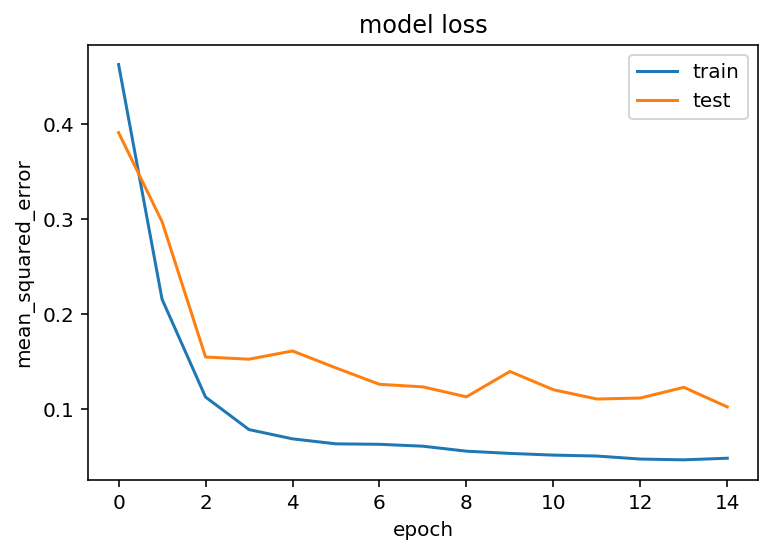

In [60]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [61]:
MLP.evaluate(val_features, val_targets)

1440/1440 [==============================] - 0s 73us/step


0.10229996796697378

In [75]:
input_dim = [train_features.shape[1]]

epochs = [10, 15, 20]
batch_size = [56, 128, 256]
lr = [0.001, 0.005, 0.01, 0.05]
hidden_nodes = [[512, 256, 128], [256, 512, 128], [256, 128], [512, 128]]

kernel_initializer = ['VarianceScaling'] # 'TruncatedNormal'
bias_initializer = ['zeros']
activation = ['sigmoid', 'relu']
loss = ['mean_squared_error']
optimizer = ['Adam']

In [76]:
param_grid = dict(input_dim = input_dim,
                  epochs = epochs,
                  batch_size = batch_size,
                  lr = lr,
                  hidden_nodes = hidden_nodes,
                  kernel_initializer = kernel_initializer,
                  bias_initializer = bias_initializer,
                  activation = activation,
                  loss = loss,
                  optimizer = optimizer)



In [77]:
param_grid

{'activation': ['sigmoid', 'relu'],
 'batch_size': [56, 128, 256],
 'bias_initializer': ['zeros'],
 'epochs': [10, 15, 20],
 'hidden_nodes': [[512, 256, 128], [256, 512, 128], [256, 128], [512, 128]],
 'input_dim': [56],
 'kernel_initializer': ['VarianceScaling'],
 'loss': ['mean_squared_error'],
 'lr': [0.001, 0.005, 0.01, 0.05],
 'optimizer': ['Adam']}

In [ ]:
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [ ]:
model = KerasRegressor(build_fn=DNN_model, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5)
grid_result = grid.fit(train_features, train_targets)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/10
12348/12348 [==============================] - 3s 259us/step - loss: 0.6005
Epoch 2/10
12348/12348 [==============================] - 2s 161us/step - loss: 0.3058
Epoch 3/10
12348/12348 [==============================] - 2s 159us/step - loss: 0.2925
Epoch 4/10
12348/12348 [==============================] - 2s 160us/step - loss: 0.2835
Epoch 5/10
12348/12348 [==============================] - 2s 163us/step - loss: 0.2741
Epoch 6/10
12348/12348 [==============================] - 2s 161us/step - loss: 0.2727
Epoch 7/10
12348/12348 [==============================] - 2s 160us/step - loss: 0.2703
Epoch 8/10
12348/12348 [==============================] - 2s 160us/step - loss: 0.2580
Epoch 9/10
12348/12348 [==============================] - 2s 163us/step - loss: 0.2502
Epoch 10/10
12348/12348 [==============================] - 1s 52us/step
Epoch 1/10
12348/12348 [==============================] - 3s 272us/step - loss: 0.5703
Epoch 2/10
12348/12348 [==============================] - 

12348/12348 [==============================] - 2s 165us/step - loss: 0.0741
Epoch 5/10
12348/12348 [==============================] - 2s 163us/step - loss: 0.0634
Epoch 6/10
12348/12348 [==============================] - 2s 164us/step - loss: 0.0617
Epoch 7/10
12348/12348 [==============================] - 2s 162us/step - loss: 0.0567
Epoch 8/10
12348/12348 [==============================] - 2s 169us/step - loss: 0.0518
Epoch 9/10
12348/12348 [==============================] - 2s 164us/step - loss: 0.0503
Epoch 10/10
12348/12348 [==============================] - 1s 53us/step
Epoch 1/10
12348/12348 [==============================] - 4s 313us/step - loss: 0.4553
Epoch 2/10
12348/12348 [==============================] - 2s 161us/step - loss: 0.1815
Epoch 3/10
12348/12348 [==============================] - 2s 160us/step - loss: 0.1232
Epoch 4/10
12348/12348 [==============================] - 2s 160us/step - loss: 0.0713
Epoch 5/10
12348/12348 [==============================] - 2s 161us/st

12348/12348 [==============================] - 2s 168us/step - loss: 1.0963
Epoch 8/10
12348/12348 [==============================] - 2s 167us/step - loss: 1.1086
Epoch 9/10
12348/12348 [==============================] - 2s 167us/step - loss: 1.1304
Epoch 10/10
12348/12348 [==============================] - 1s 54us/step
Epoch 1/10
12348/12348 [==============================] - 5s 365us/step - loss: 1.5715
Epoch 2/10
12348/12348 [==============================] - 2s 167us/step - loss: 1.1004
Epoch 3/10
12348/12348 [==============================] - 2s 169us/step - loss: 1.1054
Epoch 4/10
12348/12348 [==============================] - 2s 167us/step - loss: 1.1032
Epoch 5/10
12348/12348 [==============================] - 2s 169us/step - loss: 1.1156
Epoch 6/10
12348/12348 [==============================] - 2s 167us/step - loss: 1.1271
Epoch 7/10
12348/12348 [==============================] - 2s 169us/step - loss: 1.1319
Epoch 8/10
12348/12348 [==============================] - 2s 170us/st

12348/12348 [==============================] - 1s 62us/step
Epoch 1/10
12348/12348 [==============================] - 5s 423us/step - loss: 0.6104
Epoch 2/10
12348/12348 [==============================] - 2s 176us/step - loss: 0.2814
Epoch 3/10
12348/12348 [==============================] - 2s 180us/step - loss: 0.1572
Epoch 4/10
12348/12348 [==============================] - 2s 176us/step - loss: 0.0872
Epoch 5/10
12348/12348 [==============================] - 2s 174us/step - loss: 0.0779
Epoch 6/10
12348/12348 [==============================] - 2s 179us/step - loss: 0.0702
Epoch 7/10
12348/12348 [==============================] - 2s 178us/step - loss: 0.0661
Epoch 8/10
12348/12348 [==============================] - 2s 180us/step - loss: 0.0666
Epoch 9/10
12348/12348 [==============================] - 2s 177us/step - loss: 0.0596
Epoch 10/10
12348/12348 [==============================] - 1s 65us/step
Epoch 1/10
12348/12348 [==============================] - 5s 431us/step - loss: 0.744

12348/12348 [==============================] - 6s 469us/step - loss: 0.8424
Epoch 2/10
12348/12348 [==============================] - 2s 173us/step - loss: 0.2651
Epoch 3/10
12348/12348 [==============================] - 2s 174us/step - loss: 0.1434
Epoch 4/10
12348/12348 [==============================] - 2s 175us/step - loss: 0.0905
Epoch 5/10
12348/12348 [==============================] - 2s 175us/step - loss: 0.0656
Epoch 6/10
12348/12348 [==============================] - 2s 177us/step - loss: 0.0590
Epoch 7/10
12348/12348 [==============================] - 2s 175us/step - loss: 0.0558
Epoch 8/10
12348/12348 [==============================] - 2s 174us/step - loss: 0.0528
Epoch 9/10
12348/12348 [==============================] - 2s 175us/step - loss: 0.0486
Epoch 10/10
12348/12348 [==============================] - 1s 70us/step
Epoch 1/10
12348/12348 [==============================] - 6s 480us/step - loss: 0.4946
Epoch 2/10
12348/12348 [==============================] - 2s 178us/st

12348/12348 [==============================] - 1s 103us/step - loss: 0.2727
Epoch 5/10
12348/12348 [==============================] - 1s 108us/step - loss: 0.2575
Epoch 6/10
12348/12348 [==============================] - 1s 104us/step - loss: 0.2457
Epoch 7/10
12348/12348 [==============================] - 1s 107us/step - loss: 0.2412
Epoch 8/10
12348/12348 [==============================] - 1s 106us/step - loss: 0.2394
Epoch 9/10
12348/12348 [==============================] - 1s 104us/step - loss: 0.2345
Epoch 10/10
12348/12348 [==============================] - 1s 45us/step
Epoch 1/10
12348/12348 [==============================] - 6s 449us/step - loss: 0.6423
Epoch 2/10
12348/12348 [==============================] - 1s 105us/step - loss: 0.3388
Epoch 3/10
12348/12348 [==============================] - 1s 104us/step - loss: 0.3132
Epoch 4/10
12348/12348 [==============================] - 1s 106us/step - loss: 0.2882
Epoch 5/10
12348/12348 [==============================] - 1s 109us/st

12348/12348 [==============================] - 1s 111us/step - loss: 0.0550
Epoch 8/10
12348/12348 [==============================] - 1s 111us/step - loss: 0.0500
Epoch 9/10
12348/12348 [==============================] - 1s 110us/step - loss: 0.0486
Epoch 10/10
12348/12348 [==============================] - 1s 47us/step
Epoch 1/10
12348/12348 [==============================] - 7s 563us/step - loss: 0.5187
Epoch 2/10
12348/12348 [==============================] - 1s 115us/step - loss: 0.2190
Epoch 3/10
12348/12348 [==============================] - 1s 120us/step - loss: 0.0980
Epoch 4/10
12348/12348 [==============================] - 1s 117us/step - loss: 0.0708
Epoch 5/10
12348/12348 [==============================] - 1s 113us/step - loss: 0.0634
Epoch 6/10
 1008/12348 [=>............................] - ETA: 1s - loss: 0.0480

In [ ]:
# Load libraries
#from sklearn.preprocessing import StandardScaler
#from sklearn.dummy import DummyClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
#from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# Test options and evaluation metric
num_folds = 10
seed = 27
scoring = 'neg_mean_squared_error'

# Spot-Check Algorithms
models = []
models.append(('Dummy', DummyRegressor(strategy='median')))
models.append(('KNN', KNeighborsRegressor(n_neighbors=5)))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('ET', ExtraTreesRegressor()))
models.append(('GB', GradientBoostingRegressor()))
models.append(('AdaBoost', AdaBoostRegressor()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
#models.append(('NB', GaussianNB()))
models.append(('XGB', XGBRegressor()))

In [ ]:
# evaluate each model in turn
results = []
names = []
kfold = KFold(n_splits=num_folds, random_state=seed)
for name, model in models:
    cv_results = cross_val_score(model, train_features, train_targets, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
# Compare Algorithms
from matplotlib import pyplot

fig = pyplot.figure()
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### with hyper-parameter tune ###

In [ ]:
parameters = {}
parameters['KNN'] = {'n_neighbors': [5, 10]}
parameters['DT'] = {'max_depth':[None, 2, 5, 10]}
parameters['RF'] = {'n_estimators': [5, 10, 15, 20]}
parameters['LASSO'] = {'alpha' : [1.0, 0.8, 0.6, 0.4, 0.2, 0]}
parameters['XGB'] = {'n_estimators' : [50, 100, 150, 200], 
                    'max_depth' : [2, 4, 6, 8]}

In [ ]:
# evaluate each model with hyper-parameter tuning
from sklearn.model_selection import GridSearchCV

results = []
names = []
kfold = KFold(n_splits=num_folds, random_state=seed)
for name, model in models:
    if name in parameters.keys():
        model_tune = GridSearchCV(model, parameters[name])
        model_tune.fit(train_features, train_targets)
        model_select = model_tune.best_estimator_  #model(**model_tune.best_params_)
    else:
        model_select = model
    cv_results = cross_val_score(model_select, train_features, train_targets, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
# Compare Algorithms
from matplotlib import pyplot

fig = pyplot.figure()
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [ ]:
#https://mlwave.com/kaggle-ensembling-guide/   